In [1]:
from typing import Optional

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from map_stop_area_to_statistic_unit import (
    aggregate_to_stop_area,
    merge_stop_area_with_statistics,
)

In [2]:
CITY = "helsinki"
YEAR = 2023

In [3]:
socioecon = gpd.read_file(
    f"../../data/statistics/{CITY}/{YEAR}/statistics.geojson", engine="pyogrio"
)
income_path = "../../data/statistics/finland/001_128c_2023_20250619-123755.csv"

In [4]:
income = pd.read_csv(income_path, skiprows=1).drop("Information", axis=1)
income.columns = ["decile", "2020", "2021", "2022", "2023"]
income.loc[income.index == 0, "decile"] = "I"
income.loc[income.index == 9, "decile"] = "X"

In [5]:
# income.loc[income.index == 0, YEAR] = 12495

### Calculate % difference from Helsinki median income to low-income

In the postal code data low-income is nr of people in decile 1 and 2

High-income is nr of people in decile 9-10

So I want to calculate % difference in income from median for low and high income groups and use that in the GINI

In [6]:
# Compute Helsinki's Income Differences between median (5th decile) and low/high income
median_helsinki = income.loc[income.decile == "V", str(YEAR)]

low_deciles_avg = income.loc[income.decile.isin(["I", "II"]), str(YEAR)].mean()
high_deciles_avg = income.loc[income.decile.isin(["IX", "X"]), str(YEAR)].mean()

low_income_diff = (low_deciles_avg - median_helsinki) / median_helsinki
high_income_diff = (high_deciles_avg - median_helsinki) / median_helsinki

### Apply % difference to postal codes in socioecon

In [7]:
# Estimate Representative Incomes for Postal Codes
socioecon["Low_Income_Rep"] = socioecon["Median income of households (TR)"] * (
    1 + float(low_income_diff.iloc[0])
)
socioecon["High_Income_Rep"] = socioecon["Median income of households (TR)"] * (
    1 + float(high_income_diff.iloc[0])
)

In [8]:
# creating an array (column), where each income category is repeated the houshold nr times
# this will be used for gini calculation
def create_income_distribution(row: pd.Series) -> list[float]:
    low_income = [row["Low_Income_Rep"]] * int(
        row["Households belonging to the lowest income category (TR)"]
    )
    middle_income = [row["Median income of households (TR)"]] * int(
        row["Households belonging to the middle income category (TR)"]
    )
    high_income = [row["High_Income_Rep"]] * int(
        row["Households belonging to the highest income category (TR)"]
    )
    return low_income + middle_income + high_income


socioecon["Income_Distribution"] = socioecon.apply(create_income_distribution, axis=1)

### Compute Gini

In [9]:
def calculate_gini(array: np.array) -> Optional[np.float64]:
    """based on: https://github.com/oliviaguest/gini (CC0 1.0)"""
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0] + 1)
    # Number of array elements:
    n = array.shape[0]
    if n == 0:
        return None
    # Gini coefficient:
    return np.round((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)), 4)

In [10]:
socioecon["gini"] = socioecon["Income_Distribution"].apply(calculate_gini)

### Save relevant socioecon data

In [11]:
to_save = socioecon[
    [
        "postal_code",
        "name",
        "surface_area",
        "Low_Income_Rep",
        "High_Income_Rep",
        "Median income of households (TR)",
        "Average income of households (TR)",
        "gini",
        "Households belonging to the highest income category (TR)",
        "Households belonging to the lowest income category (TR)",
        "Households belonging to the middle income category (TR)",
        "geometry",
    ]
].rename(
    columns={
        "Low_Income_Rep": "low_inc_est",
        "High_Income_Rep": "high_inc_est",
        "Median income of households (TR)": "med_inc",
        "Average income of households (TR)": "avg_inc",
        "Households belonging to the highest income category (TR)": "hh_high",
        "Households belonging to the lowest income category (TR)": "hh_low",
        "Households belonging to the middle income category (TR)": "hh_mid",
    },
)

to_save.head()
to_save.to_file(f"../../output/{CITY}/gini.geojson")

(379043.024947, 403438.992553, 6663434.523395, 6686691.268505)

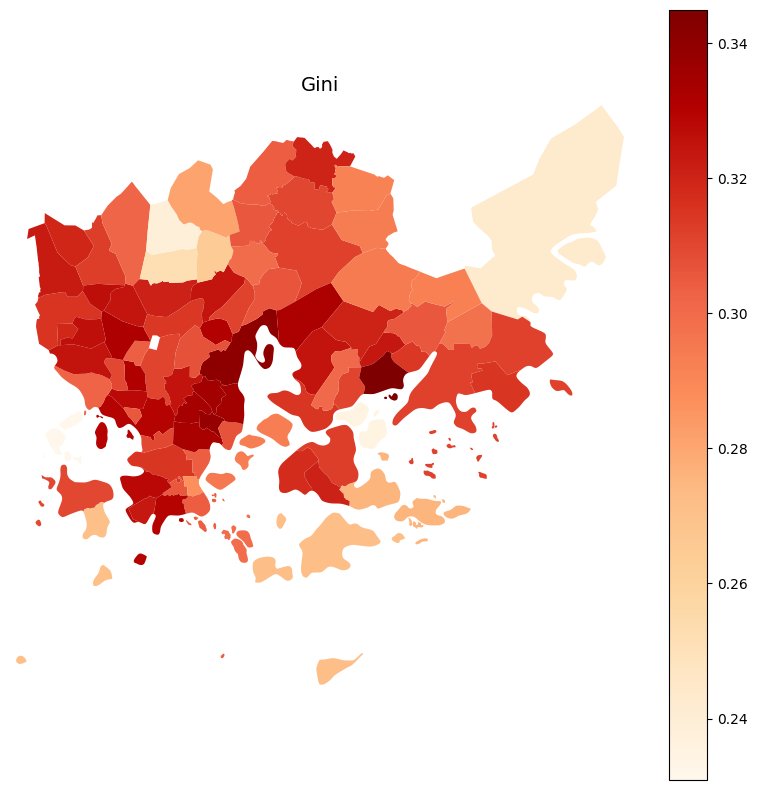

In [12]:
# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
socioecon.plot(
    column="gini",
    cmap="OrRd",  # Color scheme (e.g., 'OrRd', 'YlGnBu', 'viridis', etc.)
    legend=True,
    ax=ax,
)

# Add title and tweak the plot if needed
ax.set_title("Gini", fontsize=14)
ax.margins(0.01)
ax.axis("off")

(379043.024947, 403438.992553, 6663434.523395, 6686691.268505)

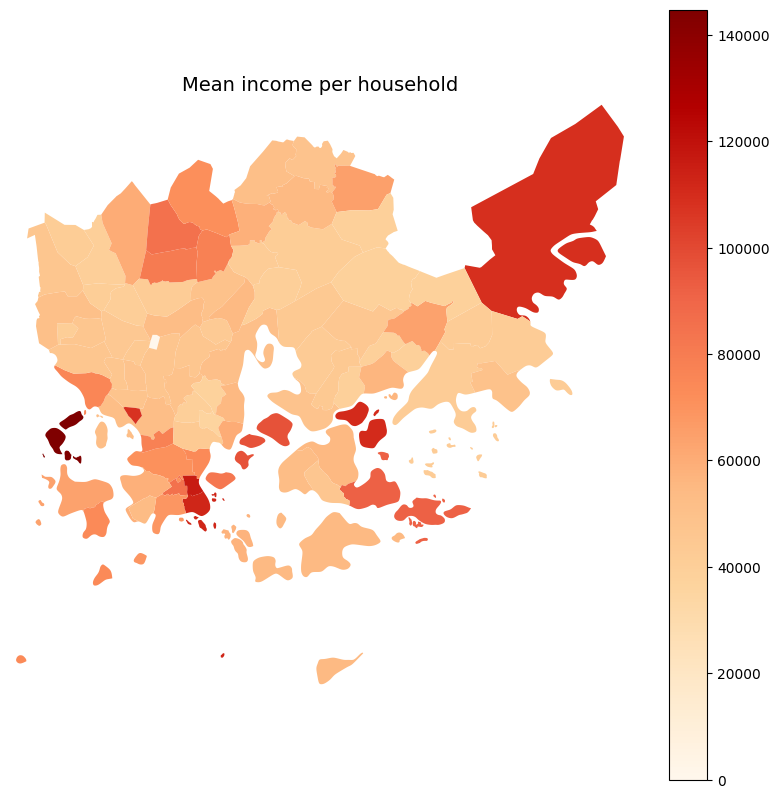

In [13]:
# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
socioecon.plot(
    column="Average income of households (TR)",
    cmap="OrRd",  # Color scheme (e.g., 'OrRd', 'YlGnBu', 'viridis', etc.)
    legend=True,
    ax=ax,
)

# Add title and tweak the plot if needed
ax.set_title("Mean income per household", fontsize=14)
ax.margins(0.01)
ax.axis("off")

(379043.024947, 403438.992553, 6663434.523395, 6686691.268505)

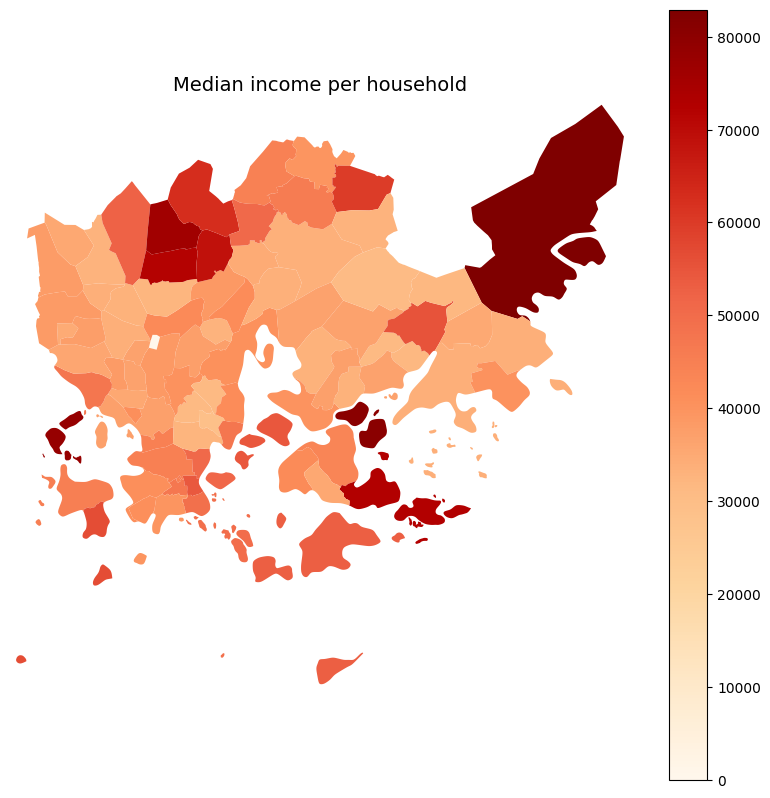

In [14]:
# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
socioecon.plot(
    column="Median income of households (TR)",
    cmap="OrRd",  # Color scheme (e.g., 'OrRd', 'YlGnBu', 'viridis', etc.)
    legend=True,
    ax=ax,
)

# Add title and tweak the plot if needed
ax.set_title("Median income per household", fontsize=14)
ax.margins(0.01)
ax.axis("off")

## Match tract shapes to walking and multimodal areas

In [15]:
CITY = "helsinki"
VERSION = "20250428"

In [16]:
with open("../../data/crs.yaml", "r") as fp:
    crs = yaml.safe_load(fp)

In [17]:
path = f"../../output/{CITY}/{VERSION}/"

multimodal = gpd.read_file(f"{path}/stop_geometries_from_walk.geojson")
multimodal["stop_id"] = multimodal["stop_id"].astype(str)
multimodal.to_crs(crs[CITY], inplace=True)

# Read GeoJSON file for 15 minute walking distance
walking = gpd.read_file(f"{path}/isochrones.geojson")
walking15 = walking[(walking["costing"] == "walk") & (walking["range"] == 15)].copy()
walking15.drop(columns=["costing", "range"], inplace=True)
walking15.to_crs(crs[CITY], inplace=True)

In [18]:
walk15_to_tract = merge_stop_area_with_statistics(
    walking15,
    socioecon,
    stat_unit_id="postal_code",
    stat_column="gini",
)
walk15_gini = aggregate_to_stop_area(walk15_to_tract, ["gini"])
walk15_gini.rename(columns={"gini": "walk15_gini"}).to_csv(
    f"{path}/walk15_stop_gini.csv", index=False, float_format="%0.06f"
)

In [19]:
multimodal_to_tract = merge_stop_area_with_statistics(
    multimodal,
    socioecon,
    stat_unit_id="postal_code",
    stat_column="gini",
)
multimodal_gini = aggregate_to_stop_area(multimodal_to_tract, ["gini"])
multimodal_gini.rename(columns={"gini": "multimodal_gini"}).to_csv(
    f"{path}/multimodal_stop_gini.csv",
    index=False,
    float_format="%0.06f",
)

In [20]:
# ref = pd.read_csv("../../output/helsinki/socioecon_merged4.csv", dtype={"stop_id": str})

In [21]:
# rw = ref[["stop_id", "weighted_gini_walk"]].merge(walk15_gini, on="stop_id")
# rw["weighted_gini_walk"].corr(rw["gini"])

In [22]:
# rm = ref[["stop_id", "weighted_gini_multi"]].merge(multimodal_gini, on="stop_id")
# rm["weighted_gini_multi"].corr(rm["gini"])

In [25]:
walk15_inc_to_tract = merge_stop_area_with_statistics(
    walking15,
    socioecon.rename(
        columns={"Median income of households (TR)": "median_income_walk"}
    ),
    stat_unit_id="postal_code",
    stat_column="median_income_walk",
)
walk15_inc = aggregate_to_stop_area(walk15_inc_to_tract, ["median_income_walk"])
walk15_inc["median_income_walk"] = round(walk15_inc["median_income_walk"])
walk15_inc[["stop_id", "median_income_walk"]].to_csv(
    f"{path}/walk15_stop_income.csv", index=False
)

In [26]:
multimodal_inc_to_tract = merge_stop_area_with_statistics(
    multimodal,
    socioecon.rename(
        columns={"Median income of households (TR)": "median_income_multimodal"}
    ),
    stat_unit_id="postal_code",
    stat_column="median_income_multimodal",
)
multimodal_inc = aggregate_to_stop_area(
    multimodal_inc_to_tract, ["median_income_multimodal"]
)
multimodal_inc["median_income_multimodal"] = round(
    multimodal_inc["median_income_multimodal"]
)
multimodal_inc[["stop_id", "median_income_multimodal"]].to_csv(
    f"{path}/multimodal_stop_income.csv", index=False
)